In [322]:
import requests
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
 # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates
print('Libraries imported.')

Libraries imported.


<h1 align=center><font size = 5>Similitudes in New York City Boroughs based on venues</font></h1>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this work I will try to find the similitudes between New York City (NYC) Boroughs through the analysis of their neighborhoods venues. The objective of this project is to apply the knowledge aqcuired through the Applied Data Science Course. 

## Data
In order to obtain the neighborhoods venues, I need to obtain the neighborhoods names and its geographical coordinates for each NYC Borough. After that, I will use the **Foursquare API** to obtain a list of nearby venues from a coordinate inside a radius of search.

I will extract the names of the NYC neighborhoods from Baruch College Website [1]. The data is presented in a table so I will use the **BeautifulSoup** Library to parse it.

Having the names of each neighborhood, I will use **geocoder** to obtain their geographical coordinates.


<a id='item1'></a>


### Creating a table with Neighborhoods names


I start communicating with the Baruch College Website. This website has a table in which each column is a NYC Borough and the rows are filled with their neighborhoods.

In [323]:
#I read the URL and I check if the response is equal to 200, which means that the file was read correctly
url = 'https://www.baruch.cuny.edu/nycdata/population-geography/neighborhoods.htm'
s = requests.Session()
response = s.get(url, timeout = 10, verify=False)
response

C:\Users\chopi\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.baruch.cuny.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>

In the next line I use the BeautifulSoup Library to see the data obtained from the website and to analyze how I will extract the table.

In [3]:
#I start to see how the table is generated in order to obtain it
soup = BeautifulSoup(response.text, 'html.parser')
soup.title.string
#soup

'NYCdata: Neighborhoods - By Borough'

I obtain the header of the table

In [326]:
table = soup.find_all('td', {"class":'header'})
header = []
for i in range(0,5):
    header.append(table[i].text)
header

['Brooklyn', 'Bronx', 'Manhattan', 'Queens', 'Staten Island']

I create a DataFrame with the header

In [325]:
df = pd.DataFrame(columns = header)
df

,Brooklyn,Bronx,Manhattan,Queens,Staten Island


The neighborhoods of Brooklyn were saved as a 'mastercol' class, and the neighborhoods of the rest of the boroughs as a 'numbers' class. Using this information I fill the dataframe using the ***find_all*** command from BeautifulSoup. When using this command I found more data than I needed so I use the method **truncate** to erase the data I don't need.

In [324]:
#I fill the column Brooklyn with its neighborhoods
table = soup.find_all('td', {"class": 'mastercol'})
brooklyn = []
for i in range(0, len(table)):
    df.loc[i, 'Brooklyn'] = table[i].text.rstrip()
df.head(4)

,Brooklyn,Bronx,Manhattan,Queens,Staten Island
0,Bath Beach,Allerton,Battery Park City,Arverne,Annadale
1,Bay Ridge,Bathgate,Beekman Place,Astoria,Arden Heights
2,Bedford Stuyvesant,Baychester,Carnegie Hill,Astoria Heights,Arlington
3,Bensonhurst,Bedford Park,Chelsea,Auburndale,Arrochar


In [7]:
#I fill the rest of the dataframe
table = soup.find_all('td', {"class":'numbers'})

four_neighborhoods= list(zip(*(iter(table),) * 4))

for i in range(0, len(four_neighborhoods)):
    neighboorgood_index = 0
    for neighborhood in four_neighborhoods[i]:
        if neighboorgood_index == 0:
            df.loc[i, 'Bronx'] = four_neighborhoods[i][neighboorgood_index].text.rstrip()
        if neighboorgood_index == 1:
            df.loc[i, 'Manhattan'] = four_neighborhoods[i][neighboorgood_index].text.rstrip()
        if neighboorgood_index == 2:
            df.loc[i, 'Queens'] = four_neighborhoods[i][neighboorgood_index].text.rstrip()
        if neighboorgood_index == 3:
            df.loc[i, 'Staten Island'] = four_neighborhoods[i][neighboorgood_index].text.rstrip()
        neighboorgood_index = neighboorgood_index + 1
df = df.truncate(after=84)
df.head(4)

,Brooklyn,Bronx,Manhattan,Queens,Staten Island
0,Bath Beach,Allerton,Battery Park City,Arverne,Annadale
1,Bay Ridge,Bathgate,Beekman Place,Astoria,Arden Heights
2,Bedford Stuyvesant,Baychester,Carnegie Hill,Astoria Heights,Arlington
3,Bensonhurst,Bedford Park,Chelsea,Auburndale,Arrochar


Finally I create a DataFrame for each Borough

In [ ]:
df_Brooklyn = df["Brooklyn"]
df_Brooklyn = df_Brooklyn.to_frame()
df_Brooklyn = df_Brooklyn.truncate(after=76)

df_Bronx = df["Bronx"]
df_Bronx = df_Bronx.to_frame()
df_Bronx = df_Bronx.truncate(after=55)

df_Manhattan = df["Manhattan"]
df_Manhattan = df_Manhattan.to_frame()
df_Manhattan = df_Manhattan.truncate(after=44)

df_Queens = df["Queens"]
df_Queens = df_Queens.to_frame()
type(df_Queens.columns[0])

df_Staten_Island = df["Staten Island"]
df_Staten_Island = df_Staten_Island.to_frame()
df_Staten_Island = df_Staten_Island.truncate(after=65)

### Obtaining the geographical coordinates for each neighborhood

I create a function which will obtain the geographical coordinates for each neighborhood using **geocoder**. With this function I will create a list containing the neighborhood name and their coordinates. Finally with the join method of pandas I will add coordinates to the DataFrame containing the neighborhoods names.

In [488]:
# define a function to get coordinates
def get_latlng(neighborhood, borough_name):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}, New York City'.format(neighborhood, borough_name))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [ ]:
coords_Brooklyn = [get_latlng(neighborhood, df_Brooklyn.columns[0]) for neighborhood in df_Brooklyn["Brooklyn"].tolist()]
a = pd.DataFrame(coords_Brooklyn, columns = ['Latitude', 'Longitude'])
df_Brooklyn = df_Brooklyn.join(a)

In [ ]:
coords_Bronx = [get_latlng(neighborhood, df_Bronx.columns[0]) for neighborhood in df_Bronx["Bronx"].tolist()]
a = pd.DataFrame(coords_Bronx, columns = ['Latitude', 'Longitude'])
df_Bronx = df_Bronx.join(a)
df_Bronx.head(2)

In [ ]:
coords_Manhattan = [get_latlng(neighborhood, df_Manhattan.columns[0]) for neighborhood in df_Manhattan["Manhattan"].tolist()]
a = pd.DataFrame(coords_Manhattan, columns = ['Latitude', 'Longitude'])
df_Manhattan = df_Manhattan.join(a)

In [ ]:
coords_Queens = [get_latlng(neighborhood, df_Queens.columns[0]) for neighborhood in df_Queens["Queens"].tolist()]
a = pd.DataFrame(coords_Queens, columns = ['Latitude', 'Longitude'])
df_Queens = df_Queens.join(a)

In [ ]:
coords_Staten_Island = [get_latlng(neighborhood, df_Staten_Island.columns[0]) for neighborhood in df_Staten_Island["Staten Island"].tolist()]
a = pd.DataFrame(coords_Staten_Island, columns = ['Latitude', 'Longitude'])
df_Staten_Island = df_Staten_Island.join(a)

I create a map of NYC with neighborhoods superimposed on top, to visualize the data obtained.


In [327]:
latitude = df_Brooklyn['Latitude'][0]
longitude = df_Brooklyn['Longitude'][0]

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map from Brooklyn
for lat, lng, neighborhood in zip(df_Brooklyn['Latitude'], df_Brooklyn['Longitude'],  df_Brooklyn['Brooklyn']):
    label = '{}, {}'.format(neighborhood, df_Brooklyn.columns[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_newyork) 
    
# add markers to map from Bronx
for lat, lng, neighborhood in zip(df_Bronx['Latitude'], df_Bronx['Longitude'],  df_Bronx['Bronx']):
    label = '{}, {}'.format(neighborhood, df_Bronx.columns[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='red', fill=True, fill_color='red', fill_opacity=0.7, parse_html=False).add_to(map_newyork)   

# add markers to map from Manhattan
for lat, lng, neighborhood in zip(df_Manhattan['Latitude'], df_Manhattan['Longitude'],  df_Manhattan['Manhattan']):
    label = '{}, {}'.format(neighborhood, df_Manhattan.columns[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='yellow', fill=True, fill_color='yellow', fill_opacity=0.7, parse_html=False).add_to(map_newyork)    

# add markers to map from Queens
for lat, lng, neighborhood in zip(df_Queens['Latitude'], df_Queens['Longitude'],  df_Queens['Queens']):
    label = '{}, {}'.format(neighborhood, df_Queens.columns[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='green', fill=True, fill_color='green', fill_opacity=0.7, parse_html=False).add_to(map_newyork)    

# add markers to map from Staten Island
for lat, lng, neighborhood in zip(df_Staten_Island['Latitude'], df_Staten_Island['Longitude'],  df_Staten_Island['Staten Island']):
    label = '{}, {}'.format(neighborhood, df_Staten_Island.columns[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='black', fill=True, fill_color='black', fill_opacity=0.7, parse_html=False).add_to(map_newyork)  
    
map_newyork

## Obtaining the venues 

I define Foursquare Credentials and Version


In [17]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J0TCWUO1VO2ZBJKJ2MKOKWXD2JUWDT4GTYPOHV55PJTIBEHK
CLIENT_SECRET:NV5KOX2T2MCDBK2Q2ACS5ELZ0O3YWFZDY5XGISBIRLCK11KR


<a id='item2'></a>


I create a function which obtains 100 nearby venues inside a 500 meters radius from a given location

In [467]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    results = 0
    venues_list=[]
    i = 1
    for name, lat, lng in zip(names, latitudes, longitudes):        
        print(i, name)
        i = i + 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

I use the function to obtain the venues close to *Breezy Point, Queens* because for some reason when I use the function shown above it doesn't work with this neighborhood

In [414]:
results = 0
radius = 500
LIMIT = 100
venues_list=[]
df_Queens[df_Queens['Queens'] == 'Breezy Point']['Latitude']
df_Queens[df_Queens['Queens'] == 'Breezy Point']['Longitude']
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items'] 

venues_list.append([('Breezy Point', 40.56142, -73.90537, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

breezy_point_nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
breezy_point_nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

I use the function on each neighborhood to create a new dataframe called manhattan_venues, queens_venues, etc.

In [468]:
# type your answer here
Manhattan_venues = getNearbyVenues(names=df_Manhattan['Manhattan'], latitudes=df_Manhattan['Latitude'], longitudes=df_Manhattan['Longitude'])
print('\n\n')
Queens_venues = getNearbyVenues(names=df_Queens['Queens'], latitudes=df_Queens['Latitude'], longitudes=df_Queens['Longitude'])
print('\n\n')
Staten_Island_venues = getNearbyVenues(names=df_Staten_Island['Staten Island'], latitudes=df_Staten_Island['Latitude'], longitudes=df_Staten_Island['Longitude'])
print('\n\n')
Bronx_venues = getNearbyVenues(names=df_Bronx['Bronx'], latitudes=df_Bronx['Latitude'], longitudes=df_Bronx['Longitude'])
print('\n\n')
Brooklyn_venues = getNearbyVenues(names=df_Brooklyn['Brooklyn'], latitudes=df_Brooklyn['Latitude'], longitudes=df_Brooklyn['Longitude'])

1 Battery Park City
2 Beekman Place
3 Carnegie Hill
4 Chelsea
5 Chinatown
6 Civic Center
7 Clinton
8 East Harlem
9 East Village
10 Financial District
11 Flatiron
12 Gramercy
13 Greenwich Village
14 Hamilton Heights
15 Harlem (Central)
16 Herald Square
17 Hudson Square
18 Inwood
19 Lenox Hill
20 Lincoln Square
21 Little Italy
22 Lower East Side
23 Manhattan Valley
24 Manhattanville
25 Midtown South
26 Midtown
27 Morningside Heights
28 Murray Hill
29 NoHo
30 Roosevelt Island
31 SoHo
32 South Village
33 Stuyvesant Town
34 Sutton Place
35 Times Square
36 Tribeca
37 Tudor City
38 Turtle Bay
39 Union Square
40 Upper East Side
41 Upper West Side
42 Wall Street
43 Washington Heights
44 West Village
45 Yorkville



1 Arverne
2 Astoria
3 Astoria Heights
4 Auburndale
5 Bay Terrace
6 Bayside
7 Bayswater
8 Beechhurst
9 Bellaire
10 Belle Harbor
11 Bellerose
12 Blissville
13 Breezy Point
14 Briarwood
15 Broad Channel
16 Brookville
17 Cambria Heights
18 Clearview
19 College Point
20 Douglaston
21 Dutc

In [469]:
Queens_venues = pd.concat([Queens_venues, breezy_point_nearby_venues]).sort_values('Neighborhood')

<a id='item3'></a>


## Methodology

In order to caracterize each borough I will create clusters with the K-means method and observe the differences between Boroughs clusters. For each neighborhood inside a cluster I will show the top 10 venues.

To obtain an optimal value of K clusters for each Borough, I will use the elbow method




 

I use the method get_dummies in order to use K-means method later on.

In [471]:
# one hot encoding for each Borough

manhattan_onehot = pd.get_dummies(Manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = Manhattan_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

queens_onehot = pd.get_dummies(Queens_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = Queens_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

staten_island_onehot = pd.get_dummies(Staten_Island_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
staten_island_onehot['Neighborhood'] = Staten_Island_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [staten_island_onehot.columns[-1]] + list(staten_island_onehot.columns[:-1])
staten_island_onehot = staten_island_onehot[fixed_columns]

bronx_onehot = pd.get_dummies(Bronx_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
bronx_onehot['Neighborhood'] = Bronx_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [bronx_onehot.columns[-1]] + list(bronx_onehot.columns[:-1])
bronx_onehot = bronx_onehot[fixed_columns]

brooklyn_onehot = pd.get_dummies(Brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = Brooklyn_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]


Now I group venues frequency by neighborhood by taking the mean of occurrence of each category


In [472]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()

queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()

staten_island_grouped = staten_island_onehot.groupby('Neighborhood').mean().reset_index()

bronx_grouped = bronx_onehot.groupby('Neighborhood').mean().reset_index()


I create a function which returns the number of top venues

In [249]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

I obtain the top 10 venues for each neighborhood

In [473]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_venues_sorted = pd.DataFrame(columns=columns)
bronx_venues_sorted = pd.DataFrame(columns=columns)
brooklyn_venues_sorted = pd.DataFrame(columns=columns)
queens_venues_sorted = pd.DataFrame(columns=columns)
staten_island_venues_sorted = pd.DataFrame(columns=columns)

manhattan_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']
bronx_venues_sorted['Neighborhood'] = bronx_grouped['Neighborhood']
brooklyn_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']
queens_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']
staten_island_venues_sorted['Neighborhood'] = staten_island_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)
    
for ind in np.arange(bronx_grouped.shape[0]):
    bronx_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bronx_grouped.iloc[ind, :], num_top_venues)
    
for ind in np.arange(brooklyn_grouped.shape[0]):
    brooklyn_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)
    
for ind in np.arange(queens_grouped.shape[0]):
    queens_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

for ind in np.arange(staten_island_grouped.shape[0]):
    staten_island_venues_sorted.iloc[ind, 1:] = return_most_common_venues(staten_island_grouped.iloc[ind, :], num_top_venues)

display('           -------Manhattan------        ', manhattan_venues_sorted.head(3),
        '           -------Bronx------            ', bronx_venues_sorted.head(3), 
        '           -------Brooklyn------         ',brooklyn_venues_sorted.head(3), 
        '           -------Queens------           ',queens_venues_sorted.head(3), 
        '           -------Staten Island------    ',staten_island_venues_sorted.head(3))



'           -------Manhattan------        '

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Park,Hotel,Plaza,Clothing Store,Gym,Memorial Site,Burger Joint,Performing Arts Venue,Shopping Mall
1,Beekman Place,Park,Coffee Shop,Italian Restaurant,Bakery,Turkish Restaurant,Bar,Hotel,Pharmacy,Wine Bar,Ramen Restaurant
2,Carnegie Hill,Café,Coffee Shop,Bookstore,Wine Shop,Bakery,Gym / Fitness Center,Gym,Art Museum,French Restaurant,Cosmetics Shop


'           -------Bronx------            '

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Sandwich Place,Donut Shop,Pharmacy,Pizza Place,Fried Chicken Joint,Discount Store,Supermarket,Fast Food Restaurant,Martial Arts School,Storage Facility
1,Bathgate,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Bank,Dessert Shop,Liquor Store,Mexican Restaurant,Donut Shop,Grocery Store
2,Baychester,Department Store,Electronics Store,Discount Store,Mexican Restaurant,Clothing Store,Spanish Restaurant,Sandwich Place,Gym / Fitness Center,Convenience Store,Fried Chicken Joint


'           -------Brooklyn------         '

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Japanese Restaurant,Pizza Place,Diner,Deli / Bodega,Event Space,Moving Target,Cantonese Restaurant,Shanghai Restaurant,Tanning Salon,Gymnastics Gym
1,Bay Ridge,Dessert Shop,Chinese Restaurant,Seafood Restaurant,Irish Pub,Park,Nightclub,Fried Chicken Joint,Gift Shop,Noodle House,Tea Room
2,Bedford Stuyvesant,Coffee Shop,Café,Caribbean Restaurant,Bar,Playground,Southern / Soul Food Restaurant,Pizza Place,Bank,Deli / Bodega,Sandwich Place


'           -------Queens------           '

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Harbor / Marina,Sandwich Place,Beach,Grocery Store,Metro Station,Donut Shop,Gas Station,Nightclub,Noodle House,Office
1,Astoria,Pizza Place,Deli / Bodega,Coffee Shop,Bar,Greek Restaurant,Falafel Restaurant,Bus Station,Restaurant,Residential Building (Apartment / Condo),Diner
2,Astoria Heights,Hookah Bar,Middle Eastern Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,Café,Gym / Fitness Center,Gym,Grocery Store,Steakhouse


'           -------Staten Island------    '

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Home Service,Weight Loss Center,Pizza Place,Bagel Shop,Gym,Accessories Store,Outdoors & Recreation,Moving Target,Museum,Music Store
1,Arden Heights,Bowling Alley,Asian Restaurant,Smoke Shop,Scenic Lookout,Trail,Outdoors & Recreation,Moving Target,Museum,Music Store,Music Venue
2,Arlington,Bus Stop,Deli / Bodega,American Restaurant,General Entertainment,Outdoors & Recreation,Museum,Music Store,Music Venue,New American Restaurant,Nightlife Spot


<a id='item4'></a>


I calculate the optimal value of clusters for K-means using the elbow method

### Manhattan

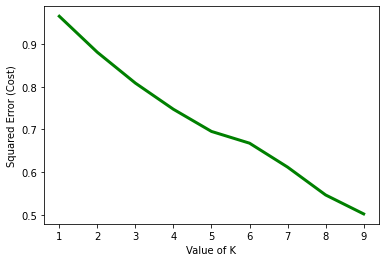

In [477]:
import matplotlib.pyplot as plt
###optimal value of k
cost = [] 
for i in range(1, 10): 
    KM = KMeans(n_clusters = i, max_iter = 100).fit(manhattan_grouped.drop('Neighborhood', 1))      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 10), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

#### Manhattan Optimal K = 5

### Bronx

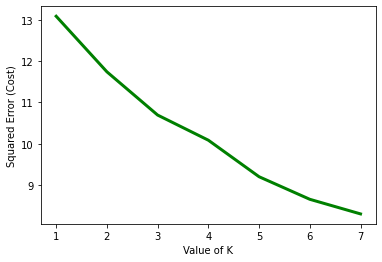

In [427]:
import matplotlib.pyplot as plt
###optimal value of k
cost = [] 
for i in range(1, 8): 
    KM = KMeans(n_clusters = i, max_iter = 500).fit(bronx_grouped.drop('Neighborhood', 1))      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 8), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

#### Bronx Optimal K = 3

### Staten Island

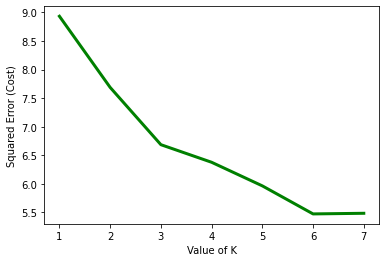

In [512]:
import matplotlib.pyplot as plt
###optimal value of k
cost = [] 
for i in range(1, 8): 
    KM = KMeans(n_clusters = i, max_iter = 500).fit(staten_island_grouped.drop('Neighborhood', 1))      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 8), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

#### Staten Island Optimal K = 3

### Brooklyn

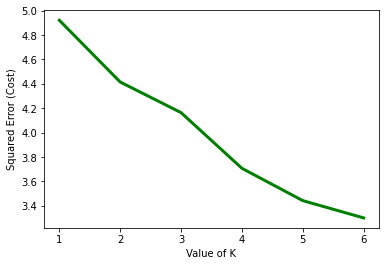

In [522]:
import matplotlib.pyplot as plt
###optimal value of k
cost = [] 
for i in range(1, 7): 
    KM = KMeans(n_clusters = i, max_iter = 500).fit(brooklyn_grouped.drop('Neighborhood', 1))      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 7), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

#### Brooklyn Optimal K = 3

### Queens

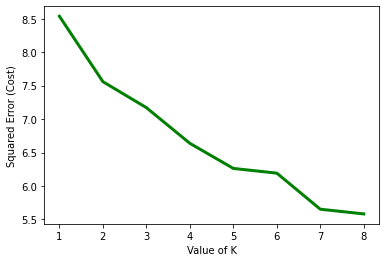

In [519]:
import matplotlib.pyplot as plt
###optimal value of k
cost = [] 
for i in range(1, 9): 
    KM = KMeans(n_clusters = i, max_iter = 50).fit(queens_grouped.drop('Neighborhood', 1))      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 9), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

#### Queens Optimal K = 4

# I start clustering with the K obtained above and adding clusters to dataframe

### Manhattan: clustering and adding clusters to dataframe

In [480]:
kclusters = 5
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)
# add clustering labels

manhattan_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
manhattan_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = df_Manhattan

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_venues_sorted.set_index('Neighborhood'), on='Manhattan')

### Manhattan: visualizing clusters 

In [481]:
# create map
map_clusters = folium.Map(location=[df_Manhattan.loc[0,'Latitude'],df_Manhattan.loc[0,'Longitude']], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Manhattan'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Manhattan Clusters: I examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### Manhattan Clusters

In [498]:
for i in range(0,6):
    print('Manhattan cluster {}'.format(i))
    display(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == i, manhattan_merged.columns[[0] + list(range(4, manhattan_merged.shape[1]))]])   


Manhattan cluster 0


,Manhattan,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Greenwich Village,Italian Restaurant,Pizza Place,Coffee Shop,American Restaurant,Sushi Restaurant,New American Restaurant,Mediterranean Restaurant,Indian Restaurant,Sandwich Place,Dessert Shop
16,Hudson Square,Italian Restaurant,Hotel,Coffee Shop,French Restaurant,American Restaurant,Sushi Restaurant,Café,Gym,Art Gallery,Cocktail Bar
30,SoHo,Italian Restaurant,Dessert Shop,Clothing Store,Hotel,Sushi Restaurant,Boutique,Bakery,French Restaurant,Coffee Shop,Café
39,Upper East Side,Italian Restaurant,Sushi Restaurant,Coffee Shop,Burger Joint,American Restaurant,Bar,Cocktail Bar,Boutique,Thai Restaurant,Salad Place
43,West Village,Italian Restaurant,Coffee Shop,Cocktail Bar,American Restaurant,Wine Bar,Cosmetics Shop,New American Restaurant,Park,Bakery,Pizza Place


Manhattan cluster 1


,Manhattan,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Chinatown,Chinese Restaurant,Bakery,Dessert Shop,Vietnamese Restaurant,Salon / Barbershop,Hotpot Restaurant,Shanghai Restaurant,Italian Restaurant,Ice Cream Shop,Bubble Tea Shop
7,East Harlem,Mexican Restaurant,Pizza Place,Bakery,Spanish Restaurant,Italian Restaurant,Cosmetics Shop,Sandwich Place,Deli / Bodega,Burger Joint,Grocery Store
14,Harlem (Central),Supermarket,Deli / Bodega,Tapas Restaurant,Baseball Field,Thrift / Vintage Store,Park,Tex-Mex Restaurant,Tennis Court,Farmers Market,Gym
17,Inwood,Spanish Restaurant,Pizza Place,Deli / Bodega,Bank,Mexican Restaurant,Latin American Restaurant,Restaurant,Wine Bar,Supermarket,Chinese Restaurant
18,Lenox Hill,Bus Station,Park,Tapas Restaurant,Donut Shop,Pizza Place,Gym,Fried Chicken Joint,Seafood Restaurant,Baseball Field,Bar
20,Little Italy,Bakery,Chinese Restaurant,Cocktail Bar,Coffee Shop,Café,Gourmet Shop,Pizza Place,Hotel,Hotpot Restaurant,Sandwich Place
21,Lower East Side,Bakery,Bar,Mexican Restaurant,Coffee Shop,Chinese Restaurant,Art Gallery,Mediterranean Restaurant,Japanese Restaurant,Bagel Shop,Latin American Restaurant
29,Roosevelt Island,Park,Food & Drink Shop,Baseball Field,Gym,Greek Restaurant,School,Farmers Market,Sandwich Place,Field,Liquor Store
42,Washington Heights,Bakery,Grocery Store,Café,Spanish Restaurant,Park,Latin American Restaurant,Donut Shop,Lounge,Chinese Restaurant,Pizza Place


Manhattan cluster 2


,Manhattan,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Herald Square,Korean Restaurant,Hotel,Coffee Shop,Gym / Fitness Center,Hotel Bar,Burger Joint,Bakery,Japanese Restaurant,Café,Indian Restaurant
24,Midtown South,Korean Restaurant,Hotel,Italian Restaurant,Café,Bakery,Gym / Fitness Center,Spa,Bar,Japanese Restaurant,Gym


Manhattan cluster 3


,Manhattan,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Park,Hotel,Plaza,Clothing Store,Gym,Memorial Site,Burger Joint,Performing Arts Venue,Shopping Mall
1,Beekman Place,Park,Coffee Shop,Italian Restaurant,Bakery,Turkish Restaurant,Bar,Hotel,Pharmacy,Wine Bar,Ramen Restaurant
2,Carnegie Hill,Café,Coffee Shop,Bookstore,Wine Shop,Bakery,Gym / Fitness Center,Gym,Art Museum,French Restaurant,Cosmetics Shop
3,Chelsea,Art Gallery,Coffee Shop,Park,Gym / Fitness Center,Café,French Restaurant,Nightclub,Bakery,Bagel Shop,Grocery Store
5,Civic Center,Coffee Shop,Chinese Restaurant,Gym / Fitness Center,Hotel,Park,Dessert Shop,Spa,Sandwich Place,Deli / Bodega,Italian Restaurant
6,Clinton,Theater,Coffee Shop,Mexican Restaurant,Wine Bar,Pizza Place,Bar,Thai Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant
8,East Village,Pizza Place,Dessert Shop,Vegetarian / Vegan Restaurant,Coffee Shop,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Filipino Restaurant
9,Financial District,Coffee Shop,Hotel,Memorial Site,Italian Restaurant,Park,Clothing Store,Café,Pizza Place,Gym / Fitness Center,Falafel Restaurant
10,Flatiron,New American Restaurant,Spa,American Restaurant,Wine Shop,Italian Restaurant,Mediterranean Restaurant,Gym / Fitness Center,Cycle Studio,Sporting Goods Shop,Café
11,Gramercy,American Restaurant,Coffee Shop,New American Restaurant,Italian Restaurant,Wine Shop,Park,Bar,Café,Juice Bar,Mediterranean Restaurant


Manhattan cluster 4


,Manhattan,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Manhattan Valley,Deli / Bodega,Cantonese Restaurant,Chinese Restaurant,Dessert Shop,Brewery,Coffee Shop,Tea Room,Cocktail Bar,Skate Park,Skating Rink
31,South Village,Brewery,Vegetarian / Vegan Restaurant,Bridge,Other Great Outdoors,Cantonese Restaurant,Skating Rink,Skate Park,Mexican Restaurant,Tea Room,Gym / Fitness Center


Manhattan cluster 5


,Manhattan,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Bronx

### Bronx: clustering and adding clusters to dataframe

In [483]:
kclusters = 3
bronx_grouped_clustering = bronx_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bronx_grouped_clustering)
#bronx_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
bronx_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
bronx_merged = df_Bronx
bronx_merged = bronx_merged.join(bronx_venues_sorted.set_index('Neighborhood'), on = 'Bronx')

### Bronx: Visualizing Clusters

In [484]:
# create map
map_clusters = folium.Map(location=[df_Bronx.loc[0,'Latitude'],df_Bronx.loc[0,'Longitude']], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.5, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx_merged['Latitude'], bronx_merged['Longitude'], bronx_merged['Bronx'], bronx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [502]:
for i in range(0,3):
    print('Bronx cluster {}'.format(i))
    display(bronx_merged.loc[bronx_merged['Cluster Labels'] == i, bronx_merged.columns[[0] + list(range(4, bronx_merged.shape[1]))]])  

Bronx cluster 0


,Bronx,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Fieldston,Pizza Place,Public Art,Sports Bar,Plaza,Bakery,Accessories Store,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park


Bronx cluster 1


,Bronx,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Sandwich Place,Donut Shop,Pharmacy,Pizza Place,Fried Chicken Joint,Discount Store,Supermarket,Fast Food Restaurant,Martial Arts School,Storage Facility
2,Baychester,Department Store,Electronics Store,Discount Store,Mexican Restaurant,Clothing Store,Spanish Restaurant,Sandwich Place,Gym / Fitness Center,Convenience Store,Fried Chicken Joint
3,Bedford Park,Pizza Place,Diner,Mexican Restaurant,Deli / Bodega,Pharmacy,Sandwich Place,Supermarket,Chinese Restaurant,Bakery,Fruit & Vegetable Store
6,Bronx Park South,Zoo Exhibit,Zoo,Park,Food Truck,Ice Cream Shop,Garden,Souvenir Shop,Fried Chicken Joint,Theater,Theme Park
7,Bronx River,Donut Shop,Bus Station,Lounge,Bus Line,Deli / Bodega,Diner,Dry Cleaner,Latin American Restaurant,Restaurant,River
9,City Island,Thrift / Vintage Store,Seafood Restaurant,Grocery Store,Boat or Ferry,Tapas Restaurant,Café,Spanish Restaurant,Deli / Bodega,Diner,Smoke Shop
12,Concourse,Deli / Bodega,Sports Bar,Lounge,Baseball Stadium,Sandwich Place,Fast Food Restaurant,Caribbean Restaurant,Smoke Shop,Ice Cream Shop,Baseball Field
13,Concourse Village,Deli / Bodega,Fast Food Restaurant,Pharmacy,Diner,Park,Sandwich Place,Coffee Shop,Supermarket,Mac & Cheese Joint,Donut Shop
14,Co-op City,Baseball Field,Accessories Store,Basketball Court,Restaurant,Donut Shop,Fast Food Restaurant,Shopping Mall,Discount Store,Post Office,Convenience Store
15,Country Club,Sandwich Place,Dog Run,Park,Athletics & Sports,Harbor / Marina,Flea Market,Pizza Place,Track,Platform,Other Nightlife


Bronx cluster 2


,Bronx,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bathgate,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Bank,Dessert Shop,Liquor Store,Mexican Restaurant,Donut Shop,Grocery Store
4,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Food & Drink Shop,Fish Market,Hotel,Grocery Store,Tattoo Parlor
5,Bronxdale,Deli / Bodega,Mexican Restaurant,Paper / Office Supplies Store,Chinese Restaurant,Pharmacy,New American Restaurant,Gym / Fitness Center,Breakfast Spot,Spanish Restaurant,Pizza Place
8,Castle Hill,Bus Station,Diner,Pharmacy,Pizza Place,Market,Cosmetics Shop,Bank,Accessories Store,Plaza,Park
10,Claremont Village,Pizza Place,Bus Station,Food,Park,Tennis Court,Grocery Store,Deli / Bodega,Chinese Restaurant,Platform,Performing Arts Venue
11,Clason Point,Deli / Bodega,Supermarket,Food,Office,Park,Wings Joint,Discount Store,Chinese Restaurant,Pizza Place,Paper / Office Supplies Store
16,East Tremont,Bank,Pizza Place,Park,Breakfast Spot,Grocery Store,Supermarket,Café,Pharmacy,Chinese Restaurant,Cosmetics Shop
19,Edgewater Park,Park,Intersection,Deli / Bodega,Boat or Ferry,Bakery,Coffee Shop,Accessories Store,Playground,Paper / Office Supplies Store,Performing Arts Venue
22,High Bridge,Supermarket,Deli / Bodega,Food,Bridge,Nightclub,Grocery Store,Gym,Music Venue,Spanish Restaurant,Pharmacy
23,Hunts Point,Deli / Bodega,BBQ Joint,Food,Pizza Place,Bank,Spanish Restaurant,Chinese Restaurant,Gym / Fitness Center,Waste Facility,Farmers Market


### Staten Island

In [504]:
kclusters = 3
staten_island_grouped_clustering = staten_island_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(staten_island_grouped_clustering) 
staten_island_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
staten_island_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
staten_island_merged = df_Staten_Island
staten_island_merged = staten_island_merged.join(staten_island_venues_sorted.set_index('Neighborhood'), on = 'Staten Island')

In [506]:
# create map
map_clusters = folium.Map(location= [df_Staten_Island.loc[0,'Latitude'],df_Staten_Island.loc[0,'Longitude']], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(staten_island_merged['Latitude'], staten_island_merged['Longitude'], staten_island_merged['Staten Island'], staten_island_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [508]:
for i in range(0,3):
    print('Staten Island cluster {}'.format(i))
    display(staten_island_merged.loc[staten_island_merged['Cluster Labels'] == i, staten_island_merged.columns[[0] + list(range(4, staten_island_merged.shape[1]))]])  

Staten Island cluster 0


,Staten Island,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Home Service,Weight Loss Center,Pizza Place,Bagel Shop,Gym,Accessories Store,Outdoors & Recreation,Moving Target,Museum,Music Store
1,Arden Heights,Bowling Alley,Asian Restaurant,Smoke Shop,Scenic Lookout,Trail,Outdoors & Recreation,Moving Target,Museum,Music Store,Music Venue
4,Bay Terrace,Italian Restaurant,Supermarket,Ice Cream Shop,Insurance Office,Home Service,Donut Shop,Bus Stop,Salon / Barbershop,Sushi Restaurant,Shipping Store
5,Bloomfield,Hotel,Cocktail Bar,Tea Room,Spa,Italian Restaurant,Home Service,Video Store,Candy Store,Museum,Music Store
6,Bulls Head,Pharmacy,Diner,Bank,Spa,Bus Stop,Café,Chinese Restaurant,Tattoo Parlor,Coffee Shop,Baseball Field
8,Castleton Corners,Pizza Place,Ice Cream Shop,Bank,Deli / Bodega,Clothing Store,Go Kart Track,Burger Joint,Grocery Store,Mexican Restaurant,Pharmacy
9,Charleston,Gym / Fitness Center,Construction & Landscaping,German Restaurant,General Entertainment,Scenic Lookout,Bakery,Food,Athletics & Sports,Restaurant,Music Venue
10,Chelsea,Boxing Gym,Bagel Shop,Discount Store,Recreation Center,Cosmetics Shop,Clothing Store,Bus Stop,Gym / Fitness Center,Department Store,Arcade
11,Clifton,Intersection,Baseball Field,Discount Store,Sandwich Place,Chinese Restaurant,Bus Stop,Grocery Store,Deli / Bodega,Lingerie Store,Pet Store
12,Concord,Peruvian Restaurant,Cosmetics Shop,Grocery Store,Gym / Fitness Center,Thrift / Vintage Store,Chinese Restaurant,Train Station,Bagel Shop,Tattoo Parlor,Pizza Place


Staten Island cluster 1


,Staten Island,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Port Ivory,Harbor / Marina,Accessories Store,Outlet Mall,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightlife Spot,Optical Shop


Staten Island cluster 2


,Staten Island,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Arlington,Bus Stop,Deli / Bodega,American Restaurant,General Entertainment,Outdoors & Recreation,Museum,Music Store,Music Venue,New American Restaurant,Nightlife Spot
3,Arrochar,Bus Stop,Deli / Bodega,Pizza Place,Bagel Shop,Outlet Mall,Museum,Music Store,Music Venue,New American Restaurant,Nightlife Spot
7,Butler Manor,Bus Stop,Sri Lankan Restaurant,Deli / Bodega,Pizza Place,Middle Eastern Restaurant,Park,Indian Restaurant,Gym,Convenience Store,Discount Store
57,Todt Hill,Pizza Place,Park,Bus Stop,Accessories Store,Other Repair Shop,Moving Target,Museum,Music Store,Music Venue,New American Restaurant
64,Willowbrook,Bus Stop,Café,Accessories Store,Outdoors & Recreation,Museum,Music Store,Music Venue,New American Restaurant,Nightlife Spot,Optical Shop
65,Woodrow,Cosmetics Shop,Medical Center,Bus Stop,Accessories Store,Outdoors & Recreation,Museum,Music Store,Music Venue,New American Restaurant,Nightlife Spot


### Brooklyn

In [517]:
kclusters = 5
brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)
brooklyn_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
brooklyn_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
brooklyn_merged = df_Brooklyn
brooklyn_merged = brooklyn_merged.join(brooklyn_venues_sorted.set_index('Neighborhood'), on = 'Brooklyn')


In [518]:
# create map
map_clusters = folium.Map(location=[df_Brooklyn.loc[0,'Latitude'], df_Brooklyn.loc[0,'Longitude']], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Brooklyn'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [524]:
for i in range(0,6):
    print('Brooklyn cluster {}'.format(i))
    display(brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == i, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]])  

Brooklyn cluster 0


,Brooklyn,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bergen Beach,Stables,Moroccan Restaurant,Noodle House,Outdoor Gym,Other Repair Shop,Other Nightlife,Other Great Outdoors,Organic Grocery,Optical Shop,Opera House


Brooklyn cluster 1


,Brooklyn,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Japanese Restaurant,Pizza Place,Diner,Deli / Bodega,Event Space,Moving Target,Cantonese Restaurant,Shanghai Restaurant,Tanning Salon,Gymnastics Gym
6,Borough Park,Restaurant,Pizza Place,Pharmacy,Bank,Grocery Store,Mobile Phone Shop,Bookstore,Hotel,Electronics Store,Deli / Bodega
8,Broadway Junction,Donut Shop,Sandwich Place,Fried Chicken Joint,Bus Station,Latin American Restaurant,Thrift / Vintage Store,Diner,Japanese Restaurant,Deli / Bodega,Caribbean Restaurant
10,Brownsville,Discount Store,Grocery Store,Women's Store,Mobile Phone Shop,Gym / Fitness Center,Metro Station,Bank,Sandwich Place,Performing Arts Venue,Pharmacy
12,Canarsie,Pharmacy,Bus Station,Caribbean Restaurant,Donut Shop,Mobile Phone Shop,Market,Metro Station,Sandwich Place,Park,Seafood Restaurant
19,Cypress Hills,Latin American Restaurant,Pizza Place,Deli / Bodega,Southern / Soul Food Restaurant,Food,Grocery Store,Gym,Metro Station,Fast Food Restaurant,Thrift / Vintage Store
20,Ditmas Park,Grocery Store,Mexican Restaurant,Restaurant,Deli / Bodega,Café,Sushi Restaurant,Halal Restaurant,Gym / Fitness Center,Fast Food Restaurant,Convenience Store
23,Dyker Heights,Deli / Bodega,Bank,Bakery,Diner,Sandwich Place,Bookstore,Bagel Shop,Pharmacy,Cosmetics Shop,Salon / Barbershop
24,East Flatbush,Caribbean Restaurant,Bank,Grocery Store,Bakery,Burger Joint,Pharmacy,Sandwich Place,Chinese Restaurant,Pizza Place,Mobile Phone Shop
25,East New York,Art Gallery,Fried Chicken Joint,Plaza,Spanish Restaurant,Pizza Place,Bus Station,Grocery Store,Opera House,Other Repair Shop,Other Nightlife


Brooklyn cluster 2


,Brooklyn,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bay Ridge,Dessert Shop,Chinese Restaurant,Seafood Restaurant,Irish Pub,Park,Nightclub,Fried Chicken Joint,Gift Shop,Noodle House,Tea Room
2,Bedford Stuyvesant,Coffee Shop,Café,Caribbean Restaurant,Bar,Playground,Southern / Soul Food Restaurant,Pizza Place,Bank,Deli / Bodega,Sandwich Place
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Supplement Shop,Asian Restaurant,Park,Bar,Liquor Store,Bakery
5,Boerum Hill,Bar,Dessert Shop,Coffee Shop,Bakery,Pizza Place,Cosmetics Shop,Dance Studio,Lounge,Burger Joint,Spa
7,Brighton Beach,Sushi Restaurant,Eastern European Restaurant,Russian Restaurant,Theater,Café,Donut Shop,Grocery Store,Bakery,Health & Beauty Service,Supermarket
9,Brooklyn Heights,Deli / Bodega,Yoga Studio,Park,Gym,Bakery,Italian Restaurant,Cosmetics Shop,Wine Shop,Coffee Shop,Pizza Place
13,Carroll Gardens,Italian Restaurant,Yoga Studio,Pizza Place,Deli / Bodega,Bar,Record Shop,Brewery,Coffee Shop,Seafood Restaurant,Sushi Restaurant
14,City Line,Gym,Pizza Place,Yoga Studio,Coffee Shop,Burger Joint,Bakery,Bagel Shop,Hotel,Grocery Store,Optical Shop
15,Clinton Hill,Pizza Place,Cocktail Bar,Italian Restaurant,Bakery,Playground,Indian Restaurant,Wine Shop,Café,Bar,Deli / Bodega
16,Cobble Hill,Playground,Bakery,Italian Restaurant,Cocktail Bar,Pizza Place,Wine Shop,Coffee Shop,Middle Eastern Restaurant,Bar,Restaurant


Brooklyn cluster 3


,Brooklyn,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Bushwick,Coffee Shop,Mediterranean Restaurant,Shop & Service,Supermarket,Mobile Phone Shop,Cocktail Bar,Yoga Studio,Outdoor Gym,Other Repair Shop,Other Nightlife


Brooklyn cluster 4


,Brooklyn,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Mill Island,Pool,Harbor / Marina,Music School,Optical Shop,Outdoors & Recreation,Outdoor Gym,Other Repair Shop,Other Nightlife,Other Great Outdoors,Organic Grocery


Brooklyn cluster 5


,Brooklyn,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Queens

In [408]:
kclusters = 5
queens_clustering = queens_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_clustering)
queens_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
queens_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
queens_merged = df_Queens
queens_merged = queens_merged.join(queens_venues_sorted.set_index('Neighborhood'), on = 'Queens')

In [410]:
# create map
map_clusters = folium.Map(location=[df_Queens.loc[0,'Latitude'], df_Queens.loc[0,'Longitude']], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Queens'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [523]:
for i in range(0,6):
    print('Queens cluster {}'.format(i))
    display(queens_merged.loc[queens_merged['Cluster Labels'] == i, queens_merged.columns[[0] + list(range(4, queens_merged.shape[1]))]])  

Queens cluster 0


,Queens,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Jamaica Estates,Bar,Beer Garden,Optical Shop,Park,Paper / Office Supplies Store,Other Repair Shop,Other Nightlife,Organic Grocery,Yoga Studio,Movie Theater


Queens cluster 1


,Queens,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Astoria,Pizza Place,Deli / Bodega,Coffee Shop,Bar,Greek Restaurant,Falafel Restaurant,Bus Station,Restaurant,Residential Building (Apartment / Condo),Diner
6,Bayswater,Chinese Restaurant,Playground,Deli / Bodega,Construction & Landscaping,Food & Drink Shop,Parking,Park,Paper / Office Supplies Store,Other Repair Shop,Other Nightlife
8,Bellaire,Deli / Bodega,Discount Store,Fried Chicken Joint,Mobile Phone Shop,Sandwich Place,Baseball Field,Donut Shop,Office,Optical Shop,Noodle House
9,Belle Harbor,Beach,Deli / Bodega,Spa,Pub,Chinese Restaurant,Bagel Shop,Italian Restaurant,Mexican Restaurant,Donut Shop,Pharmacy
11,Blissville,Intersection,Bar,Deli / Bodega,Bus Station,Rental Service,Movie Theater,Rental Car Location,Nail Salon,Nightclub,Juice Bar
13,Briarwood,Pizza Place,Dessert Shop,Plaza,Playground,Track,Trail,Yoga Studio,Noodle House,Other Nightlife,Organic Grocery
14,Broad Channel,Dive Bar,Deli / Bodega,Sporting Goods Shop,Other Nightlife,Pizza Place,Office,Paper / Office Supplies Store,Other Repair Shop,Organic Grocery,Optical Shop
19,Douglaston,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Parking,Farmers Market,Sushi Restaurant,Spa,Thai Restaurant,Greek Restaurant,Lounge
20,Dutch Kills,Recording Studio,Deli / Bodega,Pet Service,Nightclub,Optical Shop,Paper / Office Supplies Store,Other Repair Shop,Other Nightlife,Organic Grocery,Noodle House
22,Edgemere,Pizza Place,Supermarket,Seafood Restaurant,Metro Station,Scenic Lookout,Gift Shop,Skate Park,Park,Cosmetics Shop,Spa


Queens cluster 2


,Queens,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Malba,Tennis Court,Rest Area,Yoga Studio,Office,Paper / Office Supplies Store,Other Repair Shop,Other Nightlife,Organic Grocery,Optical Shop,Noodle House


Queens cluster 3


,Queens,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Harbor / Marina,Sandwich Place,Beach,Grocery Store,Metro Station,Donut Shop,Gas Station,Nightclub,Noodle House,Office
2,Astoria Heights,Hookah Bar,Middle Eastern Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,Café,Gym / Fitness Center,Gym,Grocery Store,Steakhouse
3,Auburndale,Café,Greek Restaurant,Korean Restaurant,Mobile Phone Shop,Modern Greek Restaurant,Mexican Restaurant,Pet Store,Pharmacy,Electronics Store,Sandwich Place
4,Bay Terrace,Clothing Store,Shoe Store,Women's Store,Bank,Mobile Phone Shop,Donut Shop,Cosmetics Shop,Kids Store,American Restaurant,Furniture / Home Store
5,Bayside,Sandwich Place,Korean Restaurant,Fast Food Restaurant,Pharmacy,Asian Restaurant,Coffee Shop,Convenience Store,Tea Room,Paper / Office Supplies Store,Supplement Shop
7,Beechhurst,Chinese Restaurant,Supermarket,Donut Shop,Shopping Mall,Pizza Place,Spa,Salad Place,Park,Gym,Gym / Fitness Center
10,Bellerose,Mobile Phone Shop,Gas Station,Massage Studio,Discount Store,Deli / Bodega,Pub,Cosmetics Shop,Convenience Store,Plaza,Sandwich Place
12,Breezy Point,Park,Lounge,Chinese Restaurant,Spa,Gas Station,Bus Stop,Donut Shop,Pizza Place,Soccer Field,Flower Shop
15,Brookville,Fast Food Restaurant,Intersection,Liquor Store,Clothing Store,Check Cashing Service,Caribbean Restaurant,Park,Bus Station,Gym,Bakery
16,Cambria Heights,Caribbean Restaurant,Cosmetics Shop,Nightclub,Restaurant,Intersection,Juice Bar,New American Restaurant,Nail Salon,Noodle House,Performing Arts Venue


Queens cluster 4


,Queens,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Far Rockaway,Playground,Yoga Studio,Parking,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office


Queens cluster 5


,Queens,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Results and discussion

From the clusters it can be seen that in Manhattan there is a lot of foreign gastronomy like italian, chinese, korean and mexican restaurant. Also there are plenty of Spa, Coffee Shops and Bars. This seems like a high class neighborhood. In Staten Island there is a great amount of music schools, museums, and a good balance between fast food and restaurants.
Bronx, Brooklyn and Queens seems to be more similiar, with plenty of fast food places.
This analysis could be improved if I use an optimal radius of search instead of 500 meters, to avoid having too many venues in common for each neighborhood. Another option would be to do comparisons between different venues categories such as gastronomics, bars, museums, etc.

### Conclussion

It was possible to use the tools learned in the Data Science Applied Course to obtain some similitudes between the NYC boroughs. To obtain a better distiction between boroughs a more profound analysis should be done. The tools used in this project show to have good potential to study further the characteristics of a neighborhood.

<a id='item5'></a>


### References

[1] Baruch College: New York City (NYC) Neighborhoods - By Borough. (2018).  Retrieved from https://www.baruch.cuny.edu/nycdata/population-geography/neighborhoods.htm.